# The HFM library - A fast marching solver with adaptive stencils

## Part D Applications
## Max-flow / min-cut duality, in a continuous domain.

## 0. Importing the required libraries

In [214]:
import HFMUtils
# !!! Please replace with the directory containing the FileHFM executable on your machine
HFMUtils.FileHFM_binary_dir = '/Users/mirebeau/bin/HamiltonFastMarching/FileHFM/Debug' 

In [2]:
import numpy as np
import scipy.linalg
%matplotlib inline
import matplotlib.pyplot as plt

## 1. The max-flow problem

### 1.1 Problem setting

In [369]:
hfmIn = {
    'model':'Rander2',
    'arrayOrdering':'YXZ_RowMajor',
    'exportValues':1,
    'exportGeodesicFlow':1,
    'tips':[[np.cos(t),np.sin(t)] for t in np.linspace(0,2.*np.pi)],
    'order':1,
    'stencilGeometry':'Square'
}

# Define the domain
n=101
hfmIn.update(HFMUtils.Rect([-1,-1],[1,1],dimx=n))

In [370]:
X,Y = HFMUtils.GetGrid(hfmIn)
R=np.sqrt(X**2+Y**2)
capacity = np.abs(R-0.7)+0.1

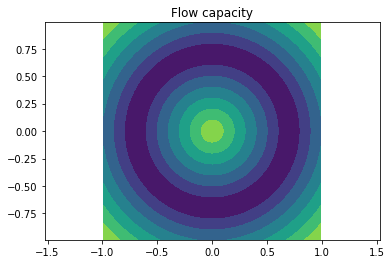

In [371]:
plt.title('Flow capacity'); plt.axis('equal')
plt.contourf(X,Y,capacity);

In [372]:
#seedRegion = (R<0.2)
#hfmIn['seeds'] = np.transpose([X[seedRegion],Y[seedRegion]])
hfmIn.update({
    'seeds':[[0,0]],
    'factoringMethod':'Static',
    'factoringRadius':200,
})

In [373]:
sinkDensity = np.clip(np.minimum(R-0.9,1.-R),a_min=0.,a_max=None)

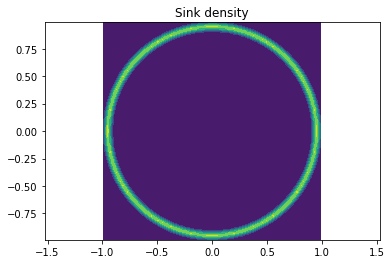

In [374]:
plt.title('Sink density'); plt.axis('equal')
plt.contourf(X,Y,sinkDensity);

In [375]:
hfmIn['metric'] = [1,0,1,0,0]

In [376]:
sinkPos = sinkDensity > 0
hfmIn['inspectSensitivity'] = np.array([X[sinkPos], Y[sinkPos]]).transpose()
hfmIn['inspectSensitivityWeights'] = sinkDensity[sinkPos]
hfmIn['inspectSensitivityLengths'] = [np.sum(sinkPos)]

In [377]:
#hfmIn['model']='Isotropic2'
#hfmIn['cost']=1

In [378]:
hfmOut = HFMUtils.Run(hfmIn)

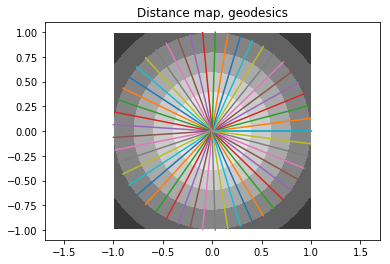

In [379]:
plt.title("Distance map, geodesics"); plt.axis('equal');
plt.contourf(X,Y,hfmOut['values'],cmap='Greys');
for geo in HFMUtils.GetGeodesics(hfmOut): plt.plot(geo[:,0],geo[:,1]) 

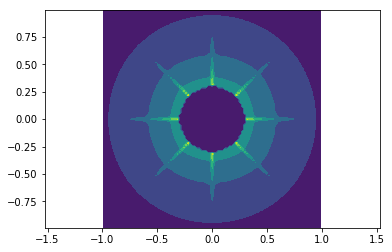

In [380]:
# Clearly, we need to get higher accuracy for the method to be applicable
sens = hfmOut['costSensitivity_0'];
R=np.sqrt(X**2+Y**2)
plt.axis('equal')
plt.contourf(X,Y,sens*(R>0.3));

In [279]:
# Absurd values in Rander case. Very strong axis bias in isotropic case.
#hfmOut['seedSensitivity_0']

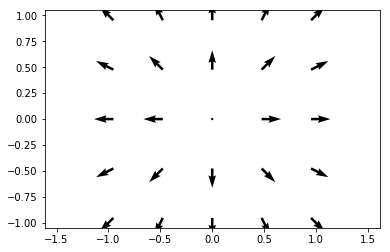

In [364]:
flow = hfmOut['geodesicFlow']
s=5;
plt.quiver(X[::s,::s],Y[::s,::s],flow[::s,::s,0],flow[::s,::s,1]); plt.axis('equal');

In [368]:
def LInfNorm(a): return np.max(np.abs(a))
print("Arrival time error : ", LInfNorm(R-hfmOut['values']))
print("Flow error, X : ", LInfNorm(flow[:,:,0]*R-X))
print("Flow error, Y : ", LInfNorm(flow[:,:,1]*R-Y))

Arrival time error :  1.7763568394002505e-15
Flow error, X :  3.3084646133829665e-14
Flow error, Y :  3.3084646133829665e-14


### 1.2 Computing an augmenting flow